# Task 3

## 0. Available adjust methods
+ Remove the Border
+ Histogram Equalization
+ White Balance
+ Brightness Adjustment
+ Contrast Adjustment
+ Saturation Adjustment
+ Sharpness Adjustment

## 1. Preview the merged image

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image, ImageEnhance
import task1loop
import task1matrix
import task2

In [2]:
raw_img = cv2.imread("test6.jpg")
raw_img.shape

(1024, 395, 3)

In [3]:
# as this is a small image, we use task1 to make alignment
merged_img = task1loop.task1("test6.jpg", 0.70, 0.50, 30, 15, 1)

[6, 14, 0, 12]
[14, 14, 0, 12]
Running time : 3.642678


In [4]:
cv2.imwrite("test6prev.jpg", merged_img)

True

In [5]:
# we use a function to compare 2 images
def compare_image(img1, img2):
    if len(img1.shape) > 2:
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    if len(img2.shape) > 2:
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(16, 8))
    ax1 = plt.subplot(121)
    ax1.imshow(img1)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2 = plt.subplot(122)
    ax2.imshow(img2)
    ax2.set_xticks([])
    ax2.set_yticks([])
    plt.show()

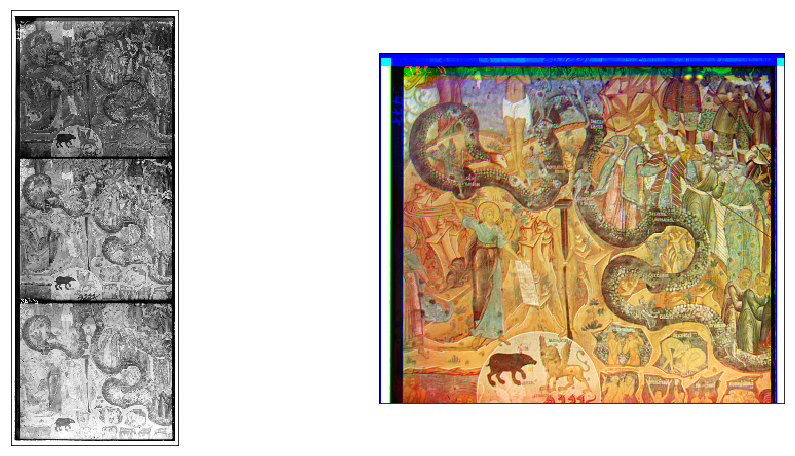

In [6]:
compare_image(raw_img, merged_img)

## 2. Remove the Border
+ Step 1: Find edge via Canny edge detection
+ Step 2: Find straight line via Hough Transform
+ Step 3: Cut the image

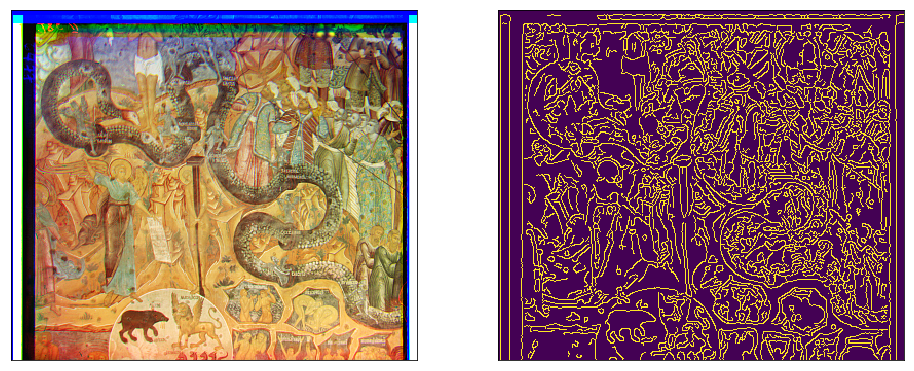

In [7]:
# Canny edge detection
gray = cv2.cvtColor(merged_img, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
edged_img = cv2.Canny(gray, 50, 100)
compare_image(merged_img, edged_img)

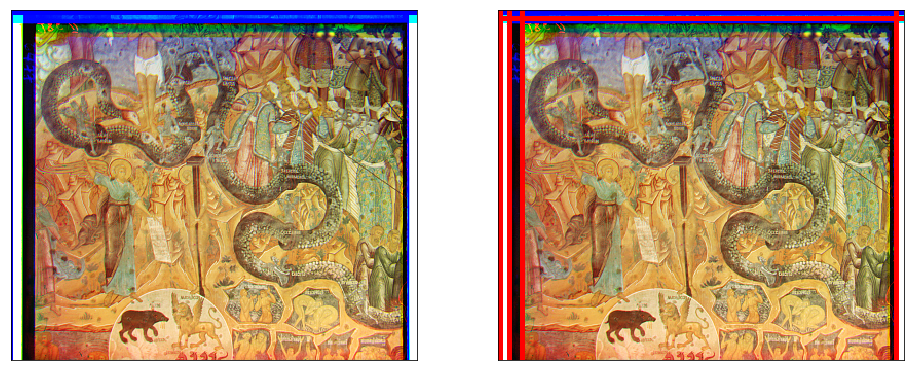

In [22]:
# Find the lines via Standard Hough Transform
lined_img = merged_img.copy()
lines = cv2.HoughLines(edged_img,1,np.pi/180,200)
# draw the lines
for rho,theta in lines[0]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv2.line(lined_img,(x1,y1),(x2,y2),(0,0,255),3)

compare_image(merged_img, lined_img)

In [25]:
# Make cut " find left_vertical, right_vertical, upper_horizontal, lower_horizontal
# set some intervals(default = 5) to make sure borders are removed
def cut(img, lines, int_upper, int_lower, int_left, int_right):
    height, width = img.shape[:2]
    left_vertical, right_vertical, upper_horizontal, lower_horizontal = 0, width - 1, 0, height - 1
    
    for rho,theta in lines[0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = int(a * rho)
        y0 = int(b * rho)
        
        if a > b : # Vertical
            if x0 < width / 2: # left_vertical
                left_vertical = max(x0, left_vertical)
            else: # right_vertical
                right_vertical = min(x0, right_vertical)
        else: # Horizontal
            if y0 < height / 2:
                upper_horizontal = max(y0, upper_horizontal)
            else:
                lower_horizontal = min(y0, lower_horizontal)
                
    return img[(upper_horizontal+int_upper):(lower_horizontal-int_lower), (left_vertical+int_left):(right_vertical-int_right), :]

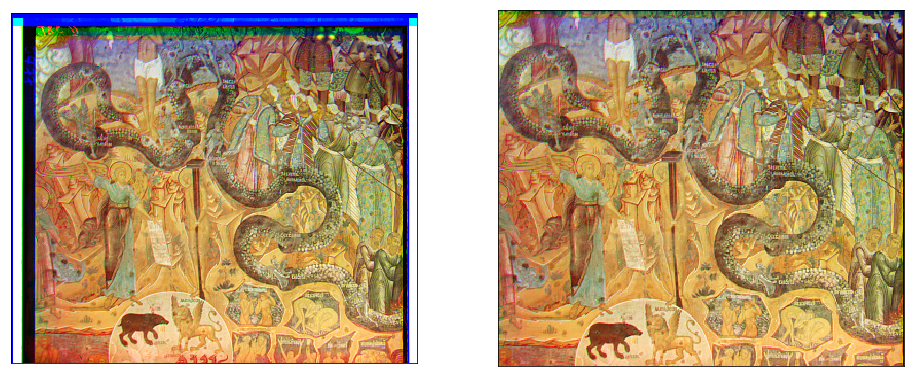

In [26]:
cutted_img = cut(merged_img, lines, 10,10,5,5)
compare_image(merged_img, cutted_img)

In [50]:
# Integrated function
def remove_border(img, kernel_size = 5, canny_min = 50, canny_max = 100, int_upper = 5, int_lower = 5, int_left = 5, int_right = 5):
    # Canny edge detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)
    edged_img = cv2.Canny(gray, canny_min, canny_max)
    # Hough transformation
    lines = cv2.HoughLines(edged_img,1,np.pi/180,200)
    # Cut the image
    cutted_img = cut(img, lines, int_upper, int_lower, int_left, int_right)
    return cutted_img

## 3. Histogram Equalization

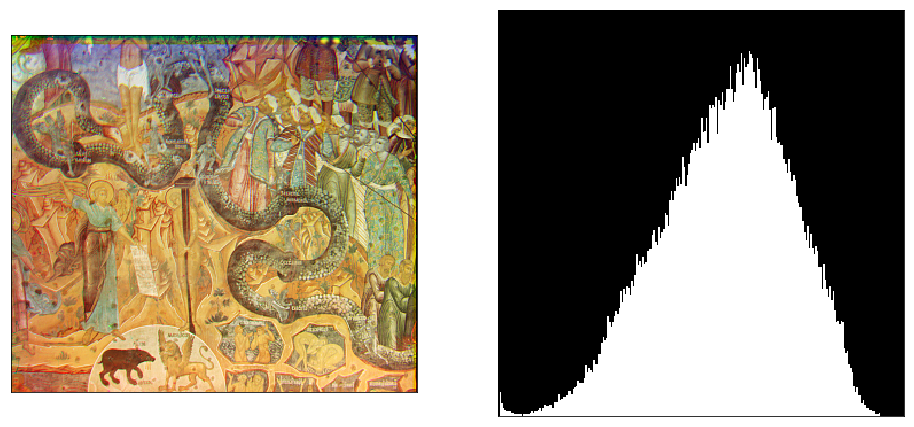

In [31]:
# Show histogram
def get_histogram(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([gray],[0],None,[256], [0.0,255.0])
    minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(hist)    
    histImg = np.zeros([256,256,3], np.uint8)    
    hpt = int(0.9 * 256)
        
    for h in range(256):    
        intensity = int(hist[h]*hpt/maxVal)    
        cv2.line(histImg,(h,256), (h,256-intensity), [255,255,255],1)
    
    return histImg

hist_img = get_histogram(cutted_img)
compare_image(cutted_img, hist_img)

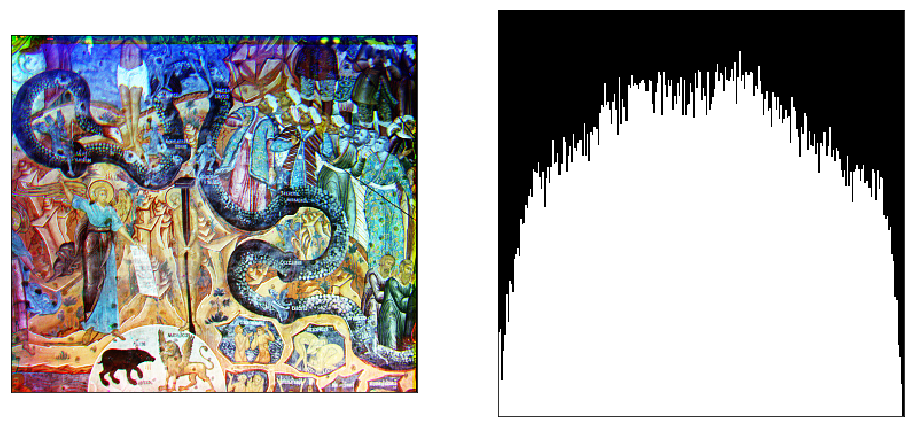

In [32]:
# Histogram Equalization
def histEq(img):
    b,g,r = cv2.split(img)
    b_eq = cv2.equalizeHist(b)
    g_eq = cv2.equalizeHist(g)
    r_eq = cv2.equalizeHist(r)
    img_output = cv2.merge([b_eq, g_eq, r_eq])
    return img_output

he_img = histEq(cutted_img)
hist_img = get_histogram(he_img)
compare_image(he_img, hist_img)

+ The result is not good, so we will not use histogram equalization here

## 3. White Balance
+ Gray world algorithm is implemented

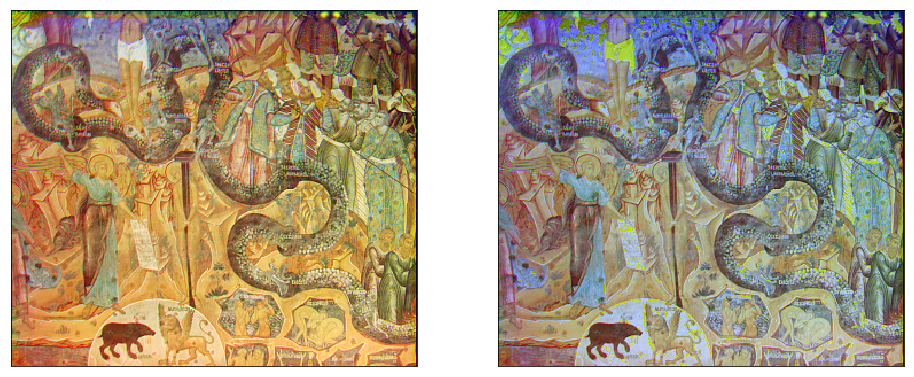

In [36]:
def white_balance_gray_world(img):
    
    img = img * 1.
    
    b,g,r = cv2.split(img)
    avgR, avgG, avgB = np.mean(r), np.mean(g), np.mean(b)
    avgGray = (avgR + avgG + avgB) / 3. ;  
    
    outR = (avgGray / avgR) * r
    outG = (avgGray / avgG) * g  
    outB = (avgGray / avgB) * b
  
    img_output = cv2.merge([outB, outG, outR]) 
    img_output = np.array(img_output, dtype = np.uint8)
    
    return img_output

balanced_img = white_balance_gray_world(cutted_img)
compare_image(cutted_img, balanced_img) 

## 4. Brightness Adjustment

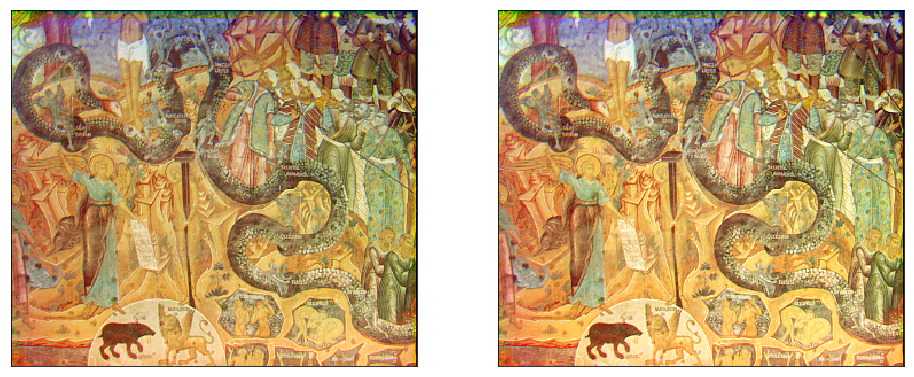

In [38]:
def brightness(img, factor):
    img_pil = Image.fromarray(img)
    img_enhanced = ImageEnhance.Brightness(img_pil).enhance(factor)
    img_cv = np.array(img_enhanced, dtype = np.uint8)
    return img_cv

brightness_img = brightness(cutted_img, 1.1)
compare_image(cutted_img, brightness_img)

## 5. Contrast Adjustment

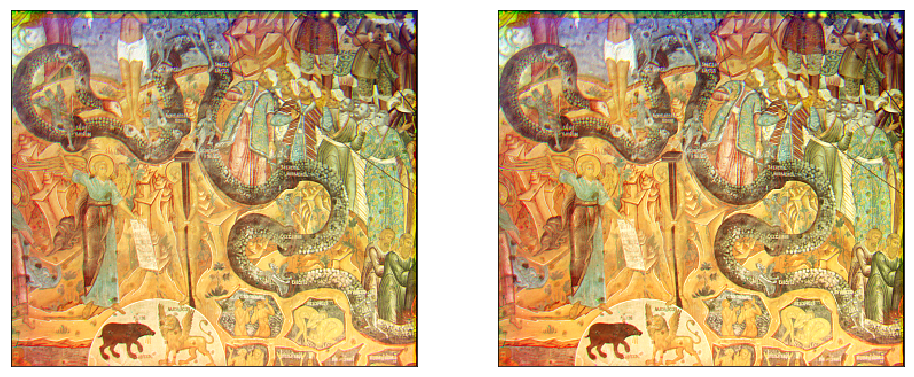

In [39]:
def contrast(img, factor):
    img_pil = Image.fromarray(img)
    img_enhanced = ImageEnhance.Contrast(img_pil).enhance(factor)
    img_cv = np.array(img_enhanced, dtype = np.uint8)
    return img_cv

contrast_img = contrast(brightness_img, 1.05)
compare_image(brightness_img, contrast_img)

## 6. Saturation Adjustment

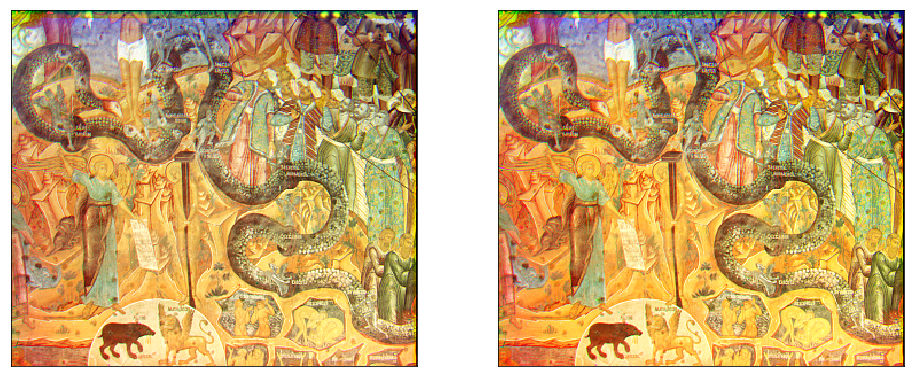

In [41]:
def color(img, factor):
    img_pil = Image.fromarray(img)
    img_enhanced = ImageEnhance.Color(img_pil).enhance(factor)
    img_cv = np.array(img_enhanced, dtype = np.uint8)
    return img_cv

color_img = color(contrast_img, 1.2)
compare_image(contrast_img, color_img)

## 7. Sharpness Adjustment
+ Already implemented in task2

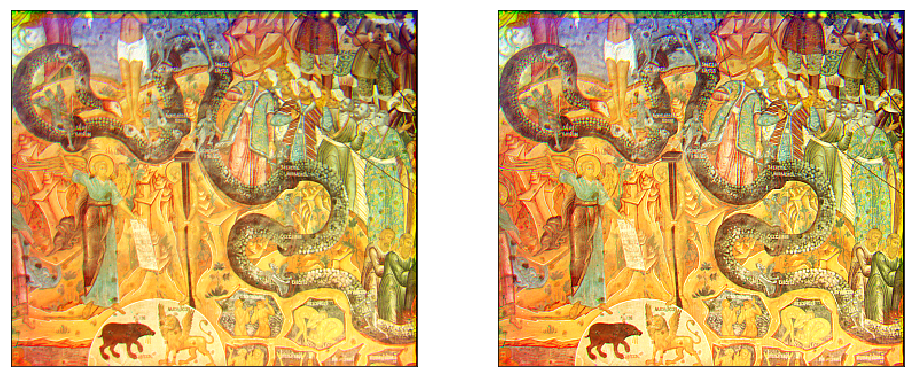

In [46]:
sharp_img = task2.sharpen(color_img, 1.5)
compare_image(color_img, sharp_img)

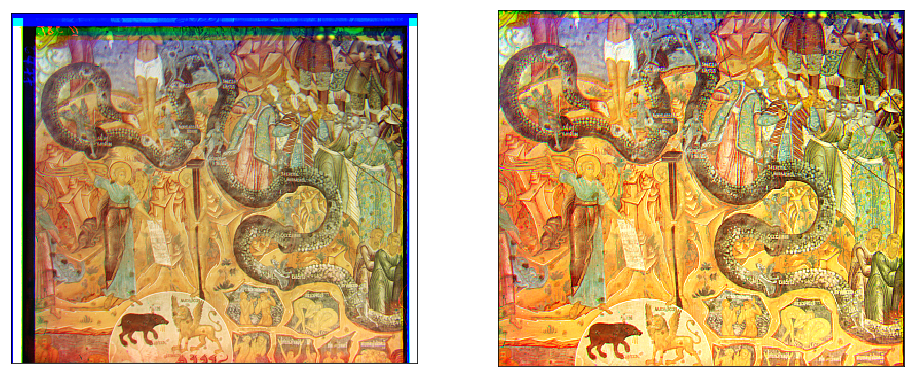

In [47]:
# Compare original image with final image
compare_image(merged_img, sharp_img)

In [48]:
cv2.imwrite("test6final.jpg", sharp_img)

True